# Re-implementation & improving of following [paper](https://www.mdpi.com/1996-1073/8/11/12337) on similar energy data by:

$Mehryar{\,}Majd$ & $Soroush{\,}Hashemifar$

## Sanitation and Analysis of Operation Data in Energy Systems

$Gerhard{\,}Zucker^1$, $Usman{\,}Habib^{1*}$, $Max{\,}Blaochle^1$, $Florian{\,}Judex^1$ and $Thomas{\,}Leber^2$

__Abstract:__ We present a workflow for data sanitation and analysis of operation data with the goal
of increasing energy efficiency and reliability in the operation of building-related energy systems.
The workflow makes use of machine learning algorithms and innovative visualizations. The
environment, in which monitoring data for energy systems are created, requires low configuration
effort for data analysis. Therefore the focus lies on methods that operate automatically and require
little or no configuration. As a result a generic workflow is created that is applicable to various
energy-related time series data; it starts with data accessibility, followed by automated detection of
duty cycles where applicable. The detection of outliers in the data and the sanitation of gaps ensure
that the data quality is sufficient for an analysis by domain experts, in our case the analysis of system
energy efficiency. To prove the feasibility of the approach, the sanitation and analysis workflow is
implemented and applied to the recorded data of a solar driven adsorption chiller.

### Sanitation and Analysis Work flow
__Data sanitation workflow__

In [1]:
# from graphviz import Source

# src = Source('digraph "the holy hand grenade" { fontsize = 5 ; rankdir=LR; Access_data -> Detect_duty_cycle -> Remove_outliers -> Sanitize_gaps -> Check_process_limits -> Analyse_data }')
# src  

#### 3.1. Making Data Accessible

In [44]:
import h5py
import numpy as np
import pandas as pd

np.random.seed(4)

def access_data():
    with h5py.File("D:\data.h5", "r") as data:
        columns = [col.decode() for col in data["dd48"]["block1_items"][()]]
        X = np.array(data["dd48"]["block1_values"][()])
        X = pd.DataFrame(X, columns=columns)

    X_nans = X.copy()
        
    for column in ['T_wall', 'T_buffertop', 'T_solV', 'T_solR', 'P_sol', 'T_bufferV', 'T_bufferR', 'T_EG', 'T_out', 'Q_heatEG', 'M_heatEG', 'W_heatEG', 'V_heatEG', 'P_heatEG', 'T_heatVEG', 'T_heatREG', 'T_buffermid', 'T_bufferlow', 'T_WWcirc']:
        X_nans[column][[2,3,34, 104, 123, 157, 158, 159, 203, 209,210,211,212,214,215]] = np.nan

#     X.iloc[87]["T_WWcirc"] = 30 # outlier
        
    return X, X_nans

#### 3.2. Duty Cycle Detection

In [2]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

def detect_on_off_states(data):
    clustering_data = data.to_numpy()
    min_max_scaler = preprocessing.MinMaxScaler()
    clustering_data = min_max_scaler.fit_transform(clustering_data)

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(clustering_data)
    cluster_labels = kmeans.predict(clustering_data)
    
    return cluster_labels, clustering_data

#### 3.3. Removal of Outliers

The working of EM algorithm can be defined as follows:
- 1) Start with guessing the initial parameters: mean and standard deviation (in case the normal
distribution model is being used).
-  2) Now enhance the parameters with E (Expectation) and M (Maximization) steps iteratively. In
the E step, the membership probability for each instance on the bases of the initial parameters is calculated. Whereas in the M step the parameters are recalculated on the base of new membership likelihoods.
- 3) Allocate each instance of the data to the cluster with which it has the highest likelihood probability.


In order to enable the EM clustering algorithm to decide the number of clusters automatically, the cross validation method is used [25,26]. The cross validation is done using the following steps:
- 1) Initially the number of clusters is set to 1.
- 2) The training set is randomly divided into 10 folds.
- 3) The Expectation Maximization (EM) is applied to each fold using cross validation.
- 4) The average log likelihood of the 10 results is calculated; if the log likelihood is increased then the
number of clusters is increased by 1 and it goes back to Step 2 again.

In [3]:
import re

def z_score_normalize(data, cycle_based=False, detected_states=None):
    if not cycle_based:
        z_score_cycle = (data - data.mean(axis=0)) / data.std(axis=0)
        z_score_cycle = z_score_cycle.to_numpy()
    else:
        z_score_cycle = data.copy()
        z_score_cycle = z_score_cycle.to_numpy()
        cycles_indices = [m.start() for m in re.finditer(r'1+0+', ''.join(map(str, detected_states)))]
        for cycle in range(len(cycles_indices)):
            if cycle == len(cycles_indices)-1:
                start, end = cycles_indices[cycle], data.shape[0]
            else:
                start, end = set(cycles_indices[cycle:cycle+2])
                
            
            z_score_cycle[start:end] = (z_score_cycle[start:end] - z_score_cycle[start:end].mean(axis=0)) / (z_score_cycle[start:end].std(axis=0)+0.00001)
    
    return z_score_cycle

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold

def find_EM_GMM_optimum(z_score_cycle):
    prev_avg_log_likelihood = -np.inf
    n_components = 1
    while True:
        avg_log_likelihood = 0
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(z_score_cycle):
            X_train, X_test = z_score_cycle[train_index], z_score_cycle[test_index]

            gmm = GaussianMixture(n_components=n_components, covariance_type = 'full')
            gmm.fit(X_train)
            avg_log_likelihood += gmm.score(X_test)

        avg_log_likelihood = avg_log_likelihood / 10

        if avg_log_likelihood < prev_avg_log_likelihood:
            print("Optimal number of components for GMM =", n_components-1)
            optimal_n_components = n_components-1
            break

        prev_avg_log_likelihood = avg_log_likelihood
        n_components += 1
        
    return optimal_n_components

In [5]:
def EM_GMM(n_components, z_score_cycle):
    gmm = GaussianMixture(n_components=optimal_n_components, covariance_type = 'full')
    gmm.fit(z_score_cycle)
    cluster_labels = gmm.predict(z_score_cycle)
    
    return cluster_labels, gmm

#### 3.4. Sanitation of Gaps

In [6]:
def train_kmeans(n_clusters, data_):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data_)
    labels = kmeans.predict(data_)

    intervals_medians = []
    for l in np.unique(labels):
        intervals_medians.append((data_[labels == l].max() + data_[labels == l].min())/2)
        
    return labels, intervals_medians, kmeans
    
def window_trick_on_labels(labels, look_before):
    new_data = []
    new_labels = []
    for j in range(0, len(labels)-look_before):
        if np.sum(np.isnan(labels[j:j+look_before+1])) == 0:
            new_data.append(labels[j:j+look_before])
            new_labels.append(labels[j+look_before])
            
    return new_data, new_labels
    
def train_svm(new_data, new_labels):
    svc = SVC(C=1, kernel="rbf")
    svc.fit(new_data, new_labels)
    
    return svc
    
def find_optimal_num_clusters_kmeans(data_, cv_splits):
    prev_avg_log_likelihood = -np.inf
    n_clusters = 2
    while True:
        avg_log_likelihood = 0
        kf = KFold(n_splits=cv_splits)
        for train_index, test_index in kf.split(data_):
            X_train, X_test = data_[train_index], data_[test_index]

            labels, intervals_medians, kmeans = train_kmeans(n_clusters, X_train)
            avg_log_likelihood += kmeans.score(X_test)

        avg_log_likelihood = avg_log_likelihood / cv_splits

        if avg_log_likelihood < prev_avg_log_likelihood:
            optimal_n_components = n_clusters-1
            break

        prev_avg_log_likelihood = avg_log_likelihood
        n_clusters += 1
        
    return optimal_n_components

In [7]:
def det_faulty_synthetic(data, valid_range):
    F = np.int0(np.logical_or(np.where(data < valid_range[0], 1, 0), np.where(data > valid_range[1], 1, 0)))
#     print(f"F flags {selected_column}:\n", F)

    S = np.int0(np.logical_or(np.where(np.isnan(data), 1, 0), F))
#     print(f"S flags {selected_column}:\n", S)
    
    return F, S

In [8]:
def predict_missing_interpolation(j, data, S):
    a = None
    b = None

    _n = 0
    for i in range(j-1, 0, -1):
        _n += 1
        if S[i] == 0:
            a = data[i]
            break

    n_ = 0
    for i in range(j+1, data.shape[0]):
        n_ += 1
        if S[i] == 0:
            b = data[i]
            break

    n = _n + n_
    
    if a == None and b != None:
        a = b
    elif a != None and b == None:
        b = a
    elif a == None and b == None:
        a = b = 0
        
    return a + ((b-a) / n)

In [9]:
def predict_missing_regression(data, cv_splits, look_before, S):
    data_ = data[~np.isnan(data)][:, np.newaxis]

    optimal_n_components = find_optimal_num_clusters_kmeans(data_, cv_splits)

    # Grouping non-missing data into various clusters
    labels, intervals_medians, kmeans = train_kmeans(optimal_n_components, data_)

    # Add nan values back to labels set
    labels_temp = np.ones((data.shape[0],)) * np.nan
    labels_temp[~np.isnan(data)] = labels
    labels = labels_temp

    # Prepare dataset for classification by utilizing window trick
    new_data, new_labels = window_trick_on_labels(labels, look_before)

    # Train SVM to classify values
    svc = train_svm(new_data, new_labels)

    # Predict missing values using SVM
    for i in range(look_before, labels.shape[0]):
        if np.isnan(labels[i]) and np.sum(np.isnan(labels[i-look_before:i])) == 0:
            labels[i] = svc.predict(labels[i-look_before:i][np.newaxis, :])[0]
            data[i] = intervals_medians[int(labels[i])]
            S[i] = 0
            
    return data, S

In [10]:
from sklearn.svm import SVC

def clean_data(X, selected_columns, valid_ranges, interpolation=True, look_before=3, cv_splits=4):
    Clean = X.copy()

    for selected_column, valid_range in zip(selected_columns, valid_ranges):
        F, S = det_faulty_synthetic(Clean[selected_column], valid_range)
        Clean[selected_column].loc[np.bool8(S)] = np.nan # Replace synthetics with NaN
        
        # Fill consecutive synthetic (interpolation)
        if interpolation:
            for j in range(Clean.shape[0]):
                if S[j] == 1:
                    Clean.iloc[j][selected_column] = predict_missing_interpolation(j, Clean[selected_column], S)
                
        # Fill consecutive synthetic (regression)
        if not interpolation:
            data = Clean[selected_column].to_numpy()
            data, S = predict_missing_regression(data, cv_splits, look_before, S)
            Clean[selected_column] = data
        
    return Clean

#### 3.5. Checking Data against Process Limits

#### 3.6. Analysis of Data

### 4. Architectural Aspects of the Data Storage and Analysis System

#### 4.1. Database System
Raw data with faulty & missing data ---> The Clean data row containing raw and synthetic data after the sanitation process

In [45]:
X, X_nans = access_data()

X.describe().iloc[[3, 7]][['T_wall', 'T_buffertop', 'T_solV', 'T_solR', 'P_sol', 
                    'T_bufferV', 'T_bufferR', 'T_EG', 'T_out', 'P_heatEG', 
                    'T_heatVEG', 'T_heatREG', 'T_buffermid', 'T_bufferlow', 'T_WWcirc']]

,T_wall,T_buffertop,T_solV,T_solR,P_sol,T_bufferV,T_bufferR,T_EG,T_out,P_heatEG,T_heatVEG,T_heatREG,T_buffermid,T_bufferlow,T_WWcirc
min,11.75,54.00,16.00,22.31,-3.744,55.01,38.69,20.1,3.7,0.0,21906.0,19850.0,50.69,24.50,23.31
max,17.88,64.56,69.75,65.50,1.023,99.99,61.38,22.6,20.4,1120.0,53813.0,42922.0,64.38,61.94,50.19


In [12]:
selected_columns = ['T_wall', 'T_buffertop', 'T_solV', 'T_solR', 'P_sol', 
                    'T_bufferV', 'T_bufferR', 'T_EG', 'T_out', 'P_heatEG', 
                    'T_heatVEG', 'T_heatREG', 'T_buffermid', 'T_bufferlow', 'T_WWcirc']
valid_ranges = [(12, 15), (54, 64), (18, 60), (23, 65), (-1, 1),
               (57, 95), (39, 61), (21, 22.5), (4, 20), (0, 1100),
               (21000, 53000), (20000, 42000), (52, 64), (25.5, 61), (24, 45)]

Clean = clean_data(X, selected_columns, valid_ranges, interpolation=True)
Clean_nans = clean_data(X_nans, selected_columns, valid_ranges, interpolation=True)
Clean

,year,month,day,hour,minute,second,epoch,DoW,pellets15,pellets_total,...,V_heatEG,P_heatEG,T_heatVEG,T_heatREG,dT_heatEG,ID,T_buffermid,T_bufferlow,T_WWcirc,rain15
0,2019.0,5.0,1.0,0.0,14.0,25.0,1.556662e+09,3.0,10.0,114450.0,...,0.0,0.0,23581.0,25306.0,1725.0,65626018.0,61.38,48.94,30.000,0.0
1,2019.0,5.0,1.0,1.0,14.0,25.0,1.556666e+09,3.0,0.0,114452.0,...,0.0,0.0,23422.0,24025.0,603.0,65626018.0,62.56,48.19,26.190,0.0
2,2019.0,5.0,1.0,2.0,14.0,25.0,1.556670e+09,3.0,0.0,114452.0,...,0.0,0.0,22891.0,23884.0,994.0,65626018.0,61.88,47.56,24.690,0.0
3,2019.0,5.0,1.0,3.0,14.0,26.0,1.556673e+09,3.0,1.0,114472.0,...,0.0,0.0,23078.0,22856.0,222.0,65626018.0,63.62,46.94,24.190,0.0
4,2019.0,5.0,1.0,4.0,14.0,25.0,1.556677e+09,3.0,0.0,114472.0,...,0.0,0.0,22566.0,22419.0,147.0,65626018.0,62.88,46.44,24.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,2019.0,5.0,12.0,5.0,14.0,24.0,1.557631e+09,7.0,1.0,123645.0,...,0.0,0.0,23538.0,21613.0,1925.0,65626018.0,62.44,37.19,26.364,1.0
270,2019.0,5.0,12.0,6.0,14.0,23.0,1.557634e+09,7.0,0.0,123655.0,...,0.0,0.0,23263.0,21397.0,1866.0,65626018.0,63.56,37.19,26.364,0.0
271,2019.0,5.0,12.0,7.0,14.0,23.0,1.557638e+09,7.0,11.0,123718.0,...,395.0,364.0,44203.0,36559.0,7644.0,65626018.0,63.00,36.94,35.060,1.0
272,2019.0,5.0,12.0,8.0,14.0,23.0,1.557642e+09,7.0,4.0,123763.0,...,403.0,257.0,44753.0,39094.0,5659.0,65626018.0,61.94,36.50,35.060,0.0


#### 4.2. Data Views
A view on the data for __legacy__ system setting all faulty and missing data to zero

In [13]:
Legacy = X_nans.copy()

for selected_column, valid_range in zip(selected_columns, valid_ranges):
    F = np.int0(np.logical_or(np.where(Legacy[selected_column] < valid_range[0], 1, 0), np.where(Legacy[selected_column] > valid_range[1], 1, 0)))
    S = np.int0(np.logical_or(np.where(np.isnan(Legacy[selected_column]), 1, 0), F))

    Legacy[selected_column][np.where(S == 1)[0]] = 0

Legacy

,year,month,day,hour,minute,second,epoch,DoW,pellets15,pellets_total,...,V_heatEG,P_heatEG,T_heatVEG,T_heatREG,dT_heatEG,ID,T_buffermid,T_bufferlow,T_WWcirc,rain15
0,2019.0,5.0,1.0,0.0,14.0,25.0,1.556662e+09,3.0,10.0,114450.0,...,0.0,0.0,23581.0,25306.0,1725.0,65626018.0,61.38,48.94,30.00,0.0
1,2019.0,5.0,1.0,1.0,14.0,25.0,1.556666e+09,3.0,0.0,114452.0,...,0.0,0.0,23422.0,24025.0,603.0,65626018.0,62.56,48.19,26.19,0.0
2,2019.0,5.0,1.0,2.0,14.0,25.0,1.556670e+09,3.0,0.0,114452.0,...,NaN,0.0,0.0,0.0,994.0,65626018.0,0.00,0.00,0.00,0.0
3,2019.0,5.0,1.0,3.0,14.0,26.0,1.556673e+09,3.0,1.0,114472.0,...,NaN,0.0,0.0,0.0,222.0,65626018.0,0.00,0.00,0.00,0.0
4,2019.0,5.0,1.0,4.0,14.0,25.0,1.556677e+09,3.0,0.0,114472.0,...,0.0,0.0,22566.0,22419.0,147.0,65626018.0,62.88,46.44,24.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,2019.0,5.0,12.0,5.0,14.0,24.0,1.557631e+09,7.0,1.0,123645.0,...,0.0,0.0,23538.0,21613.0,1925.0,65626018.0,62.44,37.19,0.00,1.0
270,2019.0,5.0,12.0,6.0,14.0,23.0,1.557634e+09,7.0,0.0,123655.0,...,0.0,0.0,23263.0,21397.0,1866.0,65626018.0,63.56,37.19,0.00,0.0
271,2019.0,5.0,12.0,7.0,14.0,23.0,1.557638e+09,7.0,11.0,123718.0,...,395.0,364.0,44203.0,36559.0,7644.0,65626018.0,63.00,36.94,35.06,1.0
272,2019.0,5.0,12.0,8.0,14.0,23.0,1.557642e+09,7.0,4.0,123763.0,...,403.0,257.0,44753.0,39094.0,5659.0,65626018.0,61.94,36.50,0.00,0.0


### 5. Demonstration System: Adsorption Chiller

#### 5.1. System Setup
Sensors: Parameters Description.

- HT_Elec: Electricity consumption meter reading at high temperature cycle
- MT_Elec: Electricity consumption meter reading at medium temperature cycle
- LT_Elec: Electricity consumption meter reading at low temperature cycle
- HT_Flow: Flow of water readings in high temperature cycle
- MT_Flow: Flow of water readings in medium temperature cycle
- LT_Flow: Flow of water readings in low temperature cycle
- T_HTre:  Temperature reading at high temperature cycle on return side
- T_HTsu:  Temperature reading at high temperature cycle on supply side
- T_MTre:  Temperature reading at medium temperature cycle on return side
- T_MTsu:  Temperature reading at medium temperature cycle on supply side
- T_LTre:  Temperature reading at low temperature cycle on return side
- T_LTsu:  Temperature reading at low temperature cycle on supply side
- QHT:     Energy consumption reading at high temperature cycle
- QMT:     Energy consumption reading at medium temperature cycle
- QLT:     Energy consumption reading at low temperature cycle

#### 5.2. Data Availibility of Monitoring Data

Calendar view of data availability: two years of operation, one system with 15 data points

#### 5.3. On/Off State Detection and Duty Cycle Detection
Automatically detected On/Off state time series using k-means clustering algorithm

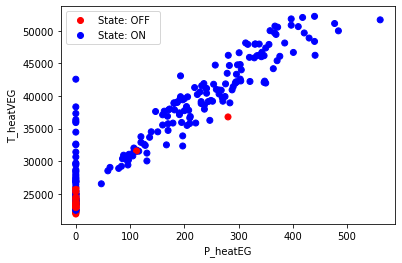

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [39]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

detected_states, _ = detect_on_off_states(Clean[selected_columns])

if detected_states[0] == 1:
    detected_states = 1-detected_states

scatter = plt.scatter(Clean["P_heatEG"], Clean["T_heatVEG"], c=detected_states , cmap=colours)
colours = ListedColormap(['r','b'])
classes = ['State: OFF  ', 'State: ON ']
plt.xlabel("P_heatEG")
plt.ylabel("T_heatVEG")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

detected_states

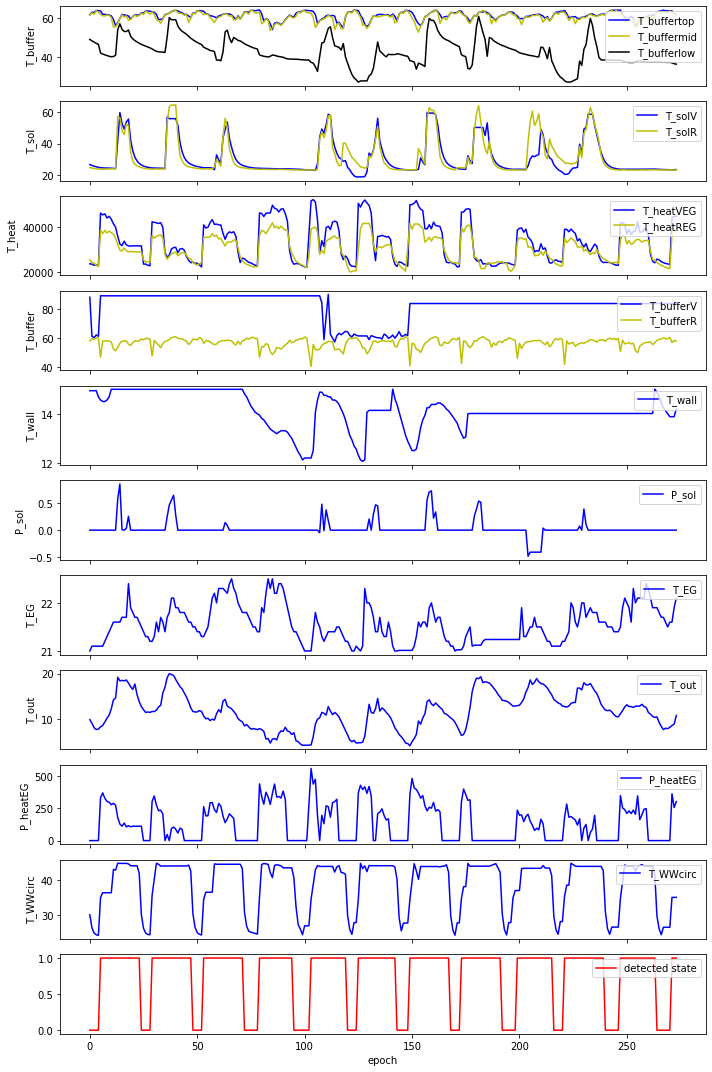

In [17]:
fig, ax = plt.subplots(nrows=11, ncols=1, figsize=(10, 15), sharex=True)

x_axis = np.arange(Clean.shape[0])

ax[0].plot(x_axis, Clean['T_buffertop'], "b", label="T_buffertop")
ax[0].plot(x_axis, Clean['T_buffermid'], "y", label="T_buffermid")
ax[0].plot(x_axis, Clean['T_bufferlow'], "k", label="T_bufferlow")
ax[0].set_ylabel("T_buffer")
ax[0].legend(loc="upper right")

ax[1].plot(x_axis, Clean['T_solV'], "b", label="T_solV")
ax[1].plot(x_axis, Clean['T_solR'], "y", label="T_solR")
ax[1].set_ylabel("T_sol")
ax[1].legend(loc="upper right")

ax[2].plot(x_axis, Clean['T_heatVEG'], "b", label="T_heatVEG")
ax[2].plot(x_axis, Clean['T_heatREG'], "y", label="T_heatREG")
ax[2].set_ylabel("T_heat")
ax[2].legend(loc="upper right")

ax[3].plot(x_axis, Clean['T_bufferV'], "b", label="T_bufferV")
ax[3].plot(x_axis, Clean['T_bufferR'], "y", label="T_bufferR")
ax[3].set_ylabel("T_buffer")
ax[3].legend(loc="upper right")

for idx, col in enumerate(["T_wall", "P_sol", "T_EG", "T_out", "P_heatEG", "T_WWcirc"]):
    ax[idx+4].plot(x_axis, Clean[col], "b", label=col)
    ax[idx+4].set_ylabel(col)
    ax[idx+4].legend(loc="upper right")
    
ax[-1].plot(x_axis, detected_states, "r", label="detected state")
ax[-1].legend(loc="upper right")

plt.xlabel("epoch")
plt.tight_layout()
plt.savefig('on_off_states.png')
plt.show()

#### 5.4. Outlier Detection using Z-score Noralization

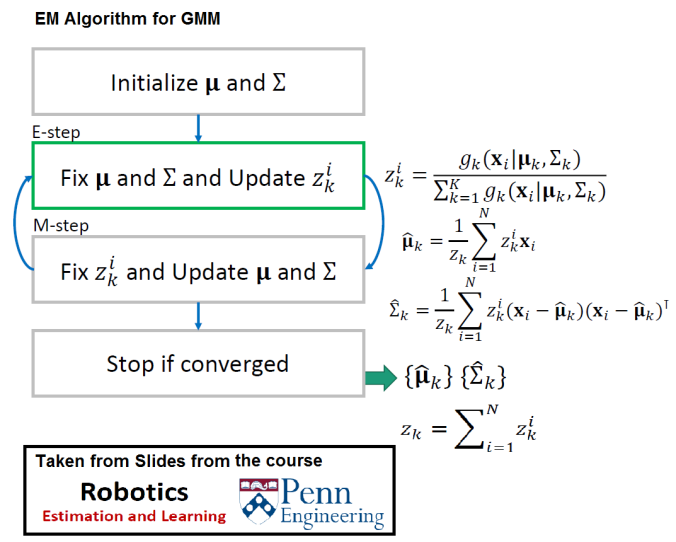

In [18]:
# from scipy.stats import multivariate_normal
# epsilon = 1e-6

# def EM4GMM(X, k, tol=0.01, max_iter=100): # k = num of mixtures
#     n, p = X.shape
    
#     phi = np.ones(k) / k
#     mu = np.random.random((k, p))
#     sigma = np.array([np.identity(p) for i in range(k)])

#     ll_old = -np.inf
#     mu_old = None
#     sigma_old = None
#     phi_old = None
#     for i in range(max_iter):
#         ll_new = 0

# #         sigma += epsilon * np.eye(sigma.shape[0])
        
#         # E-step
#         z_ki = np.zeros((k, n))
#         for j in range(k):
#             z_ki[j, :] = phi[j] * multivariate_normal(mu[j], sigma[j], allow_singular=True).pdf(X)
        
#         z_ki /= z_ki.sum(axis=0) + epsilon

#         # M-step
#         phi = 1/n * z_ki.sum(axis=1)
        
#         mu = np.dot(z_ki, X)
#         mu /= z_ki.sum(axis=1)[:, np.newaxis] + epsilon

#         sigma = np.zeros((k, p, p))
#         for j in range(k):
#             std = X - mu[j, :]
#             sigma[j] = (z_ki[j, :, np.newaxis, np.newaxis] * np.dot(std.T, std)).sum(axis=0)

# #         sigma += epsilon * np.eye(sigma.shape[0])

#         # Compute log-likelihood
#         ll_new = 0
#         for j in range(k):
#             ll_new += phi[j] * multivariate_normal(mu[j], sigma[j], allow_singular=True).pdf(X).sum()
            
#         ll_new = np.log(ll_new)

# #         print("Iteration", i, ", log-likelihood =", ll_new)
        
#         if ll_new < ll_old:
#             break
            
#         ll_old = ll_new
#         mu_old = mu
#         sigma_old = sigma
#         phi_old = phi

#     return ll_old, mu_old, sigma_old, phi_old

In [19]:
# z_score_cycle = z_score_normalize(raw_data, cycle_based=True, detected_states=detected_states[raw_data.index])

# prev_avg_log_likelihood = -np.inf
# for n_components in range(1, 50):
#     avg_log_likelihood = 0
#     kf = KFold(n_splits=10)
#     for train_index, test_index in kf.split(z_score_cycle):
#         X_train, X_test = z_score_cycle[train_index], z_score_cycle[test_index]

#         _, mu_new, sigma_new, phi_new = EM4GMM(X_train, n_components, max_iter=1000)
#         ll_new = 0
#         for j in range(n_components):
#             ll_new += phi_new[j] * multivariate_normal(mu_new[j], sigma_new[j], allow_singular=True).pdf(X_test).sum()

#         avg_log_likelihood += np.log(ll_new)

#     avg_log_likelihood = avg_log_likelihood / 10

#     if avg_log_likelihood < prev_avg_log_likelihood:
#         print("Optimal number of components for GMM =", n_components-1)
#         optimal_n_components = n_components-1
#         break

#     prev_avg_log_likelihood = avg_log_likelihood
#     print(prev_avg_log_likelihood)
    
# optimal_n_components

In [20]:
# raw_data = Clean[["T_EG", "T_WWcirc"]]

# optimal_n_components = find_EM_GMM_optimum(raw_data.to_numpy())
# gmm_labels_raw, gmm_raw = EM_GMM(optimal_n_components, raw_data.to_numpy())

# z_score_cycle = z_score_normalize(raw_data, cycle_based=True, detected_states=detected_states[raw_data.index])

# optimal_n_components = find_EM_GMM_optimum(z_score_cycle)
# gmm_labels_zscore, gmm_zscore = EM_GMM(optimal_n_components, z_score_cycle)

# plt.scatter(raw_data["T_EG"], raw_data["T_WWcirc"], c=gmm_labels_raw)
# plt.xlabel("P_heatEG")
# plt.ylabel("T_WWcirc")
# plt.show()

# plt.scatter(raw_data["T_EG"], raw_data["T_WWcirc"], c=gmm_labels_zscore)
# plt.xlabel("P_heatEG")
# plt.ylabel("T_WWcirc")
# plt.show()

In [21]:
from scipy.stats import gaussian_kde
from scipy.optimize import minimize_scalar

def detect_outliers(threshold, gmm, data):
    score_samples = gmm.score_samples(data)

    # quantile
    likelihood_threshold_ = np.quantile(score_samples, 1-threshold)

    # std-dev
    # density = gaussian_kde(score_samples)
    # max_x_value = minimize_scalar(lambda x: -density(x)).x
    # mean_likelihood = score_samples.mean()
    # new_likelihoods = score_samples[score_samples < max_x_value]
    # new_likelihoods_std = np.std(new_likelihoods - mean_likelihood)
    # likelihood_threshold_ = mean_likelihood - (threshold * new_likelihoods_std)

    predictions = -score_samples + likelihood_threshold_
    ps = (predictions >= 0)

#     plt.scatter(data["T_EG"], data["T_WWcirc"])
#     plt.scatter(data["T_EG"][ps], data["T_WWcirc"][ps], s=80, facecolors='none', edgecolors='r')
#     plt.xlabel("P_heatEG")
#     plt.ylabel("T_WWcirc")
#     plt.show()

    return ps 

In [22]:
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))

# raw_data = X[["T_EG", "T_WWcirc"]].iloc[50:100]
# detected_states, _ = detect_on_off_states(raw_data)
# z_score_cycle = z_score_normalize(raw_data, cycle_based=True, detected_states=detected_states)

# ax[0, 0].plot(raw_data.index, raw_data.to_numpy()[:, -1], "b")

# ax[0, 1].plot(raw_data.index, z_score_cycle[:, -1], "b")

# ps = detect_outliers(0.95, gmm_raw, raw_data.to_numpy())
# ax[1, 0].plot(raw_data.index, raw_data.to_numpy()[:, -1], "b")
# ax[1, 0].scatter(raw_data.index[ps], raw_data.to_numpy()[:, -1][ps], c="r")

# ps = detect_outliers(0.95, gmm_raw, z_score_cycle)
# ax[1, 1].plot(raw_data.index, z_score_cycle[:, -1], "b")
# ax[1, 1].scatter(raw_data.index[ps], z_score_cycle[:, -1][ps], c="r")


# plt.show()

Figure 8. Outlier detection using z-scores:

(a) Raw data of T_LTre; 

(b) cycle based z-score representation of the raw data; 

(c) faults detected in the raw data; 

(d) faults detected in the corresponding z-score representation.

In [23]:
def detect_outliers(cycle_based):
    raw_data = Clean[["P_heatEG", "T_WWcirc"]].iloc[50:150]

    z_score_cycle = z_score_normalize(raw_data, cycle_based=cycle_based, detected_states=detected_states[raw_data.index])

    optimal_n_components = find_EM_GMM_optimum(z_score_cycle)
    gmm_labels_zscore = EM_GMM(optimal_n_components, z_score_cycle)

    indices_zscore, counts_zscore = np.unique(gmm_labels_zscore, return_counts=True)
    print(indices_zscore, counts_zscore)
    
    return raw_data, z_score_cycle, gmm_labels_zscore, counts_zscore

In [24]:
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

# raw_data, z_score_cycle, gmm_labels_zscore, counts_zscore = detect_outliers(False)
# ax[0].plot(raw_data.index, z_score_cycle[:, -1], "b")
# if len(counts_zscore) > 1:
#     ax[0].scatter(raw_data.index[np.where(gmm_labels_zscore == np.argmin(counts_zscore), True, False)], z_score_cycle[:, -1][np.where(gmm_labels_zscore == np.argmin(counts_zscore), True, False)], c="r")

# raw_data, z_score_cycle, gmm_labels_zscore, counts_zscore = detect_outliers(True)
# ax[1].plot(raw_data.index, z_score_cycle[:, -1], "b")
# if len(counts_zscore) > 1:
#     ax[1].scatter(raw_data.index[np.where(gmm_labels_zscore == np.argmin(counts_zscore), True, False)], z_score_cycle[:, -1][np.where(gmm_labels_zscore == np.argmin(counts_zscore), True, False)], c="r")
    
# plt.show()

Figure 9. Outliers in data 

(a) Outliers detected with normal z-score 

(b) Outliers detected with cycle based z-score.

#### 5.5. Visualization of Process Limits

Figure 10. Histogram of the supply temperature in the high temperature cycle showing only the temperatures while the system is on. The data contains outliers.

Figure 11. Histogram of the return temperature in the low temperature cycle showing only the temperatures while the system is on, showing no outliers (violation bins on the left and right are empty).

#### 5.6. Analysis

#### 5.6.1. Synthetic Profiles for Large Gaps
- (1) Data is divided into a set of intervals. The length of each interval heavily affects the regression results.
- (2) Then each interval is assigned a discrete class value based on mean, mode or some other measure. Any output that will have a similar kind of interval will be assigned the same class value.

Figure 12. Sanitation of large gaps using regression

In [25]:
cleaned_data = clean_data(X_nans,
                           ["T_WWcirc"], 
                           [vr for sc, vr in zip(selected_columns, valid_ranges) if sc == "T_WWcirc"], 
                           interpolation=False, 
                           look_before=2,
                           cv_splits=4)["T_WWcirc"]

In [26]:
np.sum(np.isnan(cleaned_data))

0

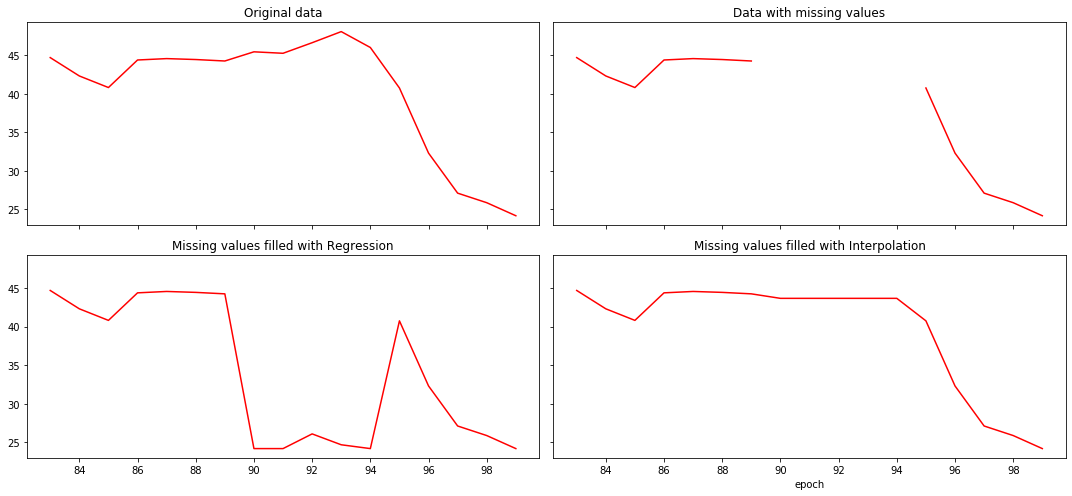

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), sharex=True, sharey=True)

raw_data = X["T_WWcirc"].iloc[83:100]

ax[0, 0].plot(raw_data.index, raw_data, "r")
ax[0, 0].set_title("Original data")

for selected_column, valid_range in zip(selected_columns, valid_ranges):
    if selected_column in ["T_WWcirc"]:
        _, S = det_faulty_synthetic(raw_data, valid_range)
        zeros_positions = [(m.start(), m.end()) for m in re.finditer(r'0+', ''.join(map(str, S)))]
        for pos in zeros_positions:
            ax[0, 1].plot(raw_data[pos[0]:pos[1]].index, raw_data[pos[0]:pos[1]], "r")
        ax[0, 1].set_title("Data with missing values")
        
ax[1, 0].plot(raw_data.index, cleaned_data.iloc[raw_data.index], "r")
ax[1, 0].set_title("Missing values filled with Regression")

ax[1, 1].plot(raw_data.index, Clean["T_WWcirc"].iloc[raw_data.index], "r")
ax[1, 1].set_title("Missing values filled with Interpolation")

plt.xlabel("epoch")
plt.tight_layout()
plt.savefig('missing_gap_filling.png')
plt.show()

#### 5.6.2. First Principle Analysis: Energy Flux Balance
Figure 13. Energy flux balance in an adsorption chiller

#### 5.6.3. Thermal Coefficient of Performance (COPtherm) Calculation
Figure 14. Coefficient of Performance (COP) on a sample‐by‐sample base and in average over the On‐state of a duty cycle.


Figure 15. Average COP per cycle histogram.